<a href="https://colab.research.google.com/github/artificiala/thai-romanization/blob/master/thai_romanize_pytorch_seq2seq_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thai to English Transliteration with Seq2Seq model

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals


In [2]:
import time
import sys
import os
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from collections import OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:
import os
from matplotlib import font_manager as fm, rcParams

fpath = os.path.join(rcParams["datapath"], "/usr/share/fonts/truetype/tlwg/Loma-Bold.ttf")
prop = fm.FontProperties(fname=fpath)
# ax.set_title('This is a special font: {}'.format(fname), fontproperties=prop)
prop

In [4]:
!nvidia-smi

Tue Aug  6 08:30:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 25%   34C    P0     1W / 250W |      0MiB / 10989MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
# Check if GPUs are in the machine, otherwise assign device as CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
!git clone https://github.com/artificiala/thai-romanization.git

fatal: destination path 'thai-romanization' already exists and is not an empty directory.


In [6]:
!ls

thai2rom-pytorch.attn.v6.best_epoch-1.tar
thai-romanization
thai-romanize-pytorch-seq2seq-attention.html
thai_romanize_pytorch_seq2seq_attention.ipynb
thai-romanize-pytorch-seq2seq-attention.ipynb


The csv file contains two columns indicates Thai text and its corresponding English tranliteration

In [7]:
DATA_PATH = '../dataset/data.csv'
!head $DATA_PATH

กองพันทหารปืนใหญ่	kongphanthahanpuenyai
วิฑูรย์	withun
เมตาบอลิสม	metabolisom
บ้านหนองเลา	bannonglao
อายุษ	ayut
แทมปา	thaempa
ประเทศกรีนแลนด์	prathetkrinlaen
พรรคคองเกรส	phakkhongkerot
การสูบ	kansup
บ้านเทพพยัคฆ์ใต้	banthepphayaktai


In [8]:

def load_data(data_path):
    with open(data_path, 'r', encoding='utf-8-sig') as f:
        lines = f.read().rstrip().split('\n')

    input_texts = []
    target_texts = []
    for line in lines:
        line = line.replace(u'\xa0',' ')
        input_text, target_text = line.split('\t')
        input_texts.append(input_text)
        target_texts.append(target_text)

    return input_texts, target_texts


In [9]:
%time input_texts, target_texts = load_data(DATA_PATH)


CPU times: user 584 ms, sys: 164 ms, total: 748 ms
Wall time: 747 ms


In [27]:
# Define special characters
UNK_token = '<UNK>'
PAD_token = '<PAD>'
START_token = '<start>'
END_token = '<end>'
MAX_LENGTH = 60

class Language:
    def __init__(self, name, is_input=False):
        self.name = name
        self.characters = set()
        self.n_chars = 0
        self.char2index = {}
        self.index2char = {}

        if is_input == True:
            self.index2char = { 0: PAD_token, 1: UNK_token, 2: START_token, 3: END_token }
            self.char2index = { ch:i for i, ch in self.index2char.items() } #reverse dictionary
            self.n_chars = 4
        else:
            self.index2char = { 0: PAD_token, 1: START_token, 2: END_token }
            self.char2index = { ch:i for i, ch in self.index2char.items() } #reverse dictionary
            self.n_chars = 3

    def addText(self, text):
        for character in text:
            self.addCharacter(character)
    
    def addCharacter(self, character):
        if character not in self.char2index.keys():
            self.char2index[character] = self.n_chars
            self.index2char[self.n_chars] = character
            self.n_chars += 1
            
            
def indexesFromText(lang, text):
    """returns indexes for all character given the text in the specified language"""
    return [lang.char2index[char] for char in text]

def tensorFromText(lang, text):
    """construct a tensor given the text in the specified language"""
    indexes = indexesFromText(lang, text)
    indexes.append(lang.char2index[END_token])
    
    no_padded_seq_length = len(indexes) # Number of characters in the text (including <END> token)
    # Add padding token to make all tensors in the same length
    for i in range(len(indexes), MAX_LENGTH): # padding
        indexes.append(lang.char2index[PAD_token])
        
    return torch.tensor(indexes, dtype=torch.long).to(device), no_padded_seq_length

def filterPair(p1, p2):
    """filter for the pair the both texts has length less than `MAX_LENGTH`"""
    return len(p1) < MAX_LENGTH and len(p2) < MAX_LENGTH

def tensorsFromPair(pair, lang1, lang2):
    """construct two tensors from a pair of source and target text specified by source and target language"""
    input_tensor, input_length = tensorFromText(lang1, pair[0])
    target_tensor, target_length = tensorFromText(lang2, pair[1])
    return input_tensor, target_tensor, input_length, target_length



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        input_text, target_text, lang_th, lang_th_romanized = sample['input_text'], sample['target_text'], \
                                                              sample['lang_th'], sample['lang_th_romanized']

        input_tensor, target_tensor, input_length, target_length = tensorsFromPair([input_text, target_text], 
                                                                                   lang_th, 
                                                                                   lang_th_romanized)
        
        return {
                'input_text': input_text,
                'target_text': target_text,
                'input_length': input_length,
                'target_length': target_length,
                'input_tensor': input_tensor,
                'target_tensor': target_tensor
               }
    
    
class ThaiRomanizationDataset(Dataset):
    """Thai Romanization Dataset class"""
    def __init__(self, 
                 data_path=DATA_PATH, 
                 transform=transforms.Compose([ ToTensor() ])):

        input_texts, target_texts = load_data(data_path)
        
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.transform = transform
        self.lang_th = None
        self.lang_th_romanized = None
        self.counter = Counter()
        self.pairs = []
        self.prepareData()

    def prepareData(self):
        self.lang_th = Language('th', is_input=True)
        self.lang_th_romanized = Language('th_romanized', is_input=False)
        for i in range(len(self.input_texts)):
            
            input_text = self.input_texts[i]
            target_text = self.target_texts[i]
            
            # Count the number of input and target sequences with length `x`
            self.counter.update({ 
                                  'len_input_{}'.format(len(input_text)): 1, 
                                  'len_target_{}'.format(len(target_text)): 1 
                                })
            
            if filterPair(input_text, target_text):
                self.pairs.append((input_text, target_text))
                self.lang_th.addText(input_text)
                self.lang_th_romanized.addText(target_text)    

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        
        sample = dict()
        sample['input_text'] = self.pairs[idx][0]
        sample['target_text'] = self.pairs[idx][1]
        
        sample['lang_th'] = self.lang_th
        sample['lang_th_romanized'] = self.lang_th_romanized

        if self.transform:
            sample = self.transform(sample)

        return sample
    

def save_model(name, epoch, loss, model):
    print('Save model at epoch ', epoch)
    torch.save({
        'epoch': epoch,
        'loss': loss,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'char_to_ix': thai_romanization_dataset.lang_th.char2index,
        'ix_to_char': thai_romanization_dataset.lang_th.index2char,
        'target_char_to_ix': thai_romanization_dataset.lang_th_romanized.char2index,
        'ix_to_target_char':thai_romanization_dataset.lang_th_romanized.index2char,
        'encoder_params': (INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT), 
        'decoder_params': (OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT)
        
    }, "{}.best_epoch-{}.tar".format(name, epoch))
    
 
    
def load_model(model_path):
    
    data = torch.load(model_path)
    
    INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT = data['encoder_params']
    OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT = data['decoder_params']

    
    encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM).to(device)
    decoder = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM).to(device)

    model = Seq2Seq(encoder, decoder).to(device)
    
    model.load_state_dict(data['model_state_dict'])
    
    
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(data['optimizer_state_dict'])
    criterion = nn.CrossEntropyLoss(ignore_index = 0)

    char_to_ix = data['char_to_ix']
    ix_to_char = data['ix_to_char'] 
    target_char_to_ix = data['target_char_to_ix']
    ix_to_target_char = data['ix_to_target_char']
    
    
    return {
        'model': model,
        'optmizer': optimizer,
        'char_to_ix': char_to_ix,
        'ix_to_char' : ix_to_char,
        'target_char_to_ix': target_char_to_ix,
        'ix_to_target_char': ix_to_target_char
    }
       

In [11]:
thai_romanization_dataset = ThaiRomanizationDataset()

In [12]:
thai_romanization_dataset.lang_th_romanized.index2char

{0: '<PAD>',
 1: '<start>',
 2: '<end>',
 3: 'k',
 4: 'o',
 5: 'n',
 6: 'g',
 7: 'p',
 8: 'h',
 9: 'a',
 10: 't',
 11: 'u',
 12: 'e',
 13: 'y',
 14: 'i',
 15: 'w',
 16: 'm',
 17: 'b',
 18: 'l',
 19: 's',
 20: 'r',
 21: 'd',
 22: 'c',
 23: 'f',
 24: '-',
 25: ' ',
 26: '2',
 27: '1',
 28: '4',
 29: '8',
 30: '3',
 31: '5',
 32: '7',
 33: '0',
 34: '6',
 35: '9',
 36: '"',
 37: '!',
 38: '(',
 39: ')'}

## Seq2Seq Model architecture

## 1. Encoder

Encoder 
    - Embedding layer :(vocaburay_size, embedding_size) 
        Input: (batch_size, sequence_length)
        Output: (batch_size, sequence_length, embebeding_size)
      
    - Bi-LSTM layer : (input_size, hidden_size, num_layers, batch_first=True)
        Input: (input=(batch_size, seq_len, embebeding_size),  hidden)
        Output: (output=(batch_size, seq_len, hidden_size),
                 (h_n, c_n))
     
     
__Steps:__

1. Receives a batch of source sequences (batch_size, MAX_LENGTH) and a 1-D array of the length for each sequence (batch_size).
     
2. Sort sequences in the batch by sequence length (number of tokens in the sequence where <PAD> token is excluded).

3. Feed the batch of sorted sequences into the Embedding Layer to maps source character indices into vectors. (batch_size,  sequence_length, embebeding_size)

4. Use `pack_padded_sequence` to let LSTM packed input with same length at time step $t$ together. This will reduce time required for training by avoid feeding `<PAD>` token to the LSTMs.


5. Returns LSTM outputs in the unsorted order, and the LSTM hidden state vectors.
     

In [79]:


class Encoder(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, dropout=0.5):
        """Constructor"""
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.character_embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = nn.LSTM(input_size=embedding_size, 
                            hidden_size=hidden_size // 2, 
                            bidirectional=True,
                            batch_first=True)
        
        self.dropout = nn.Dropout(dropout)


    def forward(self, sequences, sequences_lengths):
        batch_size = sequences.size(0)
        hidden = self.init_hidden(batch_size) # batch_size

#         print('encoder, hidden:', hidden)
        # sequences :(batch_size, sequence_length=MAX_LENGTH)
        # sequences_lengths: (batch_size)  # an 1-D indicating length of each sequence (excluded <PAD> token) in `seq`
        
        # 1. Firstly we sort `sequences_lengths` according to theirs values and keep list of indexes to perform sorting
        sequences_lengths = np.sort(sequences_lengths)[::-1] # sort in ascending order and reverse it
        index_sorted = np.argsort(-sequences_lengths) # use negation in sort in descending order
        index_unsort = np.argsort(index_sorted) # to unsorted sequence
        
        
        # 2. Then, we change position of sequence in `sequences` according to `index_sorted`
        index_sorted = torch.from_numpy(index_sorted)
        sequences = sequences.index_select(0, index_sorted.to(device))
        
        # 3. Feed to Embedding Layer
        
        sequences = self.character_embedding(sequences)
        sequences = self.dropout(sequences)
        
#         print('sequences',sequences.size(), sequences)
            
        # 3. Use function: pack_padded_sequence to let LSTM packed input with same length at time step T together
        
        # Quick fix: Use seq_len.copy(), instead of seq_len to fix `Torch.from_numpy not support negative strides`
        # ndarray.copy() will alocate new memory for numpy array which make it normal, I mean the stride is not negative any more.

        sequences_packed = nn.utils.rnn.pack_padded_sequence(sequences,
                                                             sequences_lengths.copy(),
                                                             batch_first=True)
#         print('sequences_packed', sequences_packed)

        # 4. Feed to LSTM
        sequences_output, hidden = self.rnn(sequences_packed, hidden)
        
        # 5. Unpack
        sequences_output, _ = nn.utils.rnn.pad_packed_sequence(sequences_output, batch_first=True)

        # 6. Un-sort by length
        index_unsort = torch.from_numpy(index_unsort).to(device)
        sequences_output = sequences_output.index_select(0, Variable(index_unsort))

#         print('hidden shape', self.hidden[0].shape, self.hidden[0], self.hidden[1].shape, self.hidden[1])
        return sequences_output, hidden
    
    def init_hidden(self, batch_size):
        h_0 = torch.zeros([2, batch_size, self.hidden_size // 2], requires_grad=True).to(device)
        c_0 = torch.zeros([2, batch_size, self.hidden_size // 2], requires_grad=True).to(device)

        return (h_0, c_0)
    

## Test encoder

In [80]:
### Testing Encoder part
# TODO: put whether GPU is available or not
# Device

INPUT_DIM = len(thai_romanization_dataset.lang_th.char2index)
OUTPUT_DIM = len(thai_romanization_dataset.lang_th_romanized.char2index)

ENC_EMB_DIM = 10
ENC_HID_DIM = 10
ENC_DROPOUT = 0.5

_encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM).to(device)

# obtain one sample from the data iterator

for batch in train_dataset_loader:
    print(batch)
    
    input_tensor, input_length, target_tensor = batch['input_tensor'], batch['input_length'], batch['target_tensor']
    
    output, hidden = _encoder(input_tensor, input_length)
    
    print('input_tensor', input_tensor.size())
    print('input_length', input_length.size())
    print('target_tensor', target_tensor.size())
    print('output', output.size())
    print('hidden[0]', hidden[0].size(), hidden[0])
    print('hidden[1]', hidden[0].size(), hidden[1])


    break

{'input_text': ['พักษ์', 'กิติโชติ อมรรัตนบงกช'], 'target_text': ['phak', 'kitichot amonrattanabongkot'], 'input_length': tensor([ 6, 21]), 'target_length': tensor([ 5, 28]), 'input_tensor': tensor([[ 7,  8,  4, 33, 24,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 4, 20, 27, 20, 41, 43, 27, 20, 56,  5, 26, 13, 13,  8, 27,  9, 28,  6,
          4, 43,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0]], device='cuda:0'), 'target_tensor': tensor([[ 7,  8,  9,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

## Decoder

   
Decoder architecture

    - Embedding layer :(vocabulary_size, embebeding_size)
        Input: (batch_size, sequence_length=1)
        Output: (batch_size, sequence_length=1, embebeding_size)
    - RNN layer :input_size=embebeding_size, hidden_size, num_layers, batch_first=True)
        Input: (input=(batch_size, input_size=embedding_dimension), hidden:tuple=encoder_hidden
        Output: (batch_size, seq_len, hidden_size), (h_n, c_n)
    - Attention Layer: (in_features=hidden_size, out_features=hidden_size, bias=True)
    - Linear Layer: (in_features, out_features=vocabulary_size)
        Input: (batch_size, hidden_size)
        Output: (batch_size, vocabulary_size)
    
    - Softmax layer
        Input: (batch_size, vocabulary_size)
        Output: (batch_size, vocabulary_size)



For the Attention mechanishm in the Decoder, Luong-style attention [[Luong et. al (2015)](https://arxiv.org/abs/1508.04025)] is used. 



__Steps:__

1. Receives a batch of <start> token (batch_size, 1) and a batch of Encoder's hidden state.
     
2. Embed input into vectors.

3. Feed vectors from (2) to the LSTM.

4. Feed the output of LSTM at time step $t_1$ and Encoder output to the Attention Layer.

5. Attention layer, returns weights for Encoder's hidden states in every time step (masked out the time step with <PAD> token), then multiply with Encoder's hidden states to obtain a context vector
    
6. Concatenate both decoder hidden state and the context vector, feed to a linear layer, and return its output.

7. Decoder then returns, final output, decoder's hidden state, attention weights, and context vector at time step $t$

In [107]:

class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()

        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, self.hidden_size))

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: B x 1 x h ; 
        # encoder_outputs: B x S x h

        # Calculate energies for each encoder output
        if self.method == 'dot':
            attn_energies = torch.bmm(encoder_outputs, hidden.transpose(1, 2)).squeeze(2)  # B x S
        elif self.method == 'general':
            attn_energies = self.attn(encoder_outputs.view(-1, encoder_outputs.size(-1)))  # (B * S) x h
            attn_energies = torch.bmm(attn_energies.view(*encoder_outputs.size()),
                                      hidden.transpose(1, 2)).squeeze(2)  # B x S
        elif self.method == 'concat':
            attn_energies = self.attn(
                torch.cat((hidden.expand(*encoder_outputs.size()), encoder_outputs), 2))  # B x S x h
            attn_energies = torch.bmm(attn_energies,
                                      self.other.unsqueeze(0).expand(*hidden.size()).transpose(1, 2)).squeeze(2)

        attn_energies = attn_energies.masked_fill(mask == 0, -1e10)

        # Normalize energies to weights in range 0 to 1
        return F.softmax(attn_energies, 1)

class AttentionDecoder(nn.Module): 
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, dropout=0.5):
        """Constructor"""
        super(AttentionDecoder, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.hidden_size = hidden_size
        self.character_embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = nn.LSTM(input_size=hidden_size + embedding_size,
                            hidden_size=hidden_size,
                            bidirectional=False,
                            batch_first=True)
        
        self.attn = Attn(method="general", hidden_size=self.hidden_size)
        self.linear = nn.Linear( hidden_size, vocabulary_size)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, input, last_hidden, encoder_outputs, mask):
        """"Defines the forward computation of the decoder"""
        # input: (B, 1) ,
        # last_hidden: (num_layers * num_directions = 2, B, hidden_dim)
        # encoder_outputs: (B, S, hidden_dim)
        
        # last_hidden from  (batch_size, hidden size)
        # to (batch_size, 1, hidden size)
        hidden = last_hidden.permute(1, 0, 2)
#         print('unsqueeze hidden.size()', hidden.size())

        attn_weights = self.attn(hidden, encoder_outputs, mask)  # B x S

        #  context = (B, 1, S) x (B, S, hidden_dim)
        #  context = (B, 1, hidden_dim)
        context_vector = attn_weights.unsqueeze(1).bmm(encoder_outputs)  
        #  context after sum = (B, hidden_dim)
        context_vector = torch.sum(context_vector, dim=1)
        
        
        embedded = self.character_embedding(input)
        embedded = self.dropout(embedded)
        
        # context_vector = (B, hidden_dim)
        # embedded = (B, emb_dim)
        # rnn_input = (B, hidden_dim + emb_dim)
        context_vector = context_vector.unsqueeze(1)
        
#         print('context_vector', context_vector.size())
#         print('embedded', embedded.size())
        rnn_input = torch.cat((context_vector, embedded), -1)
    
        # output (batch_size, 1, hidden_dim)
        output, hidden = self.rnn(rnn_input)        
        
#         print('hidden[0].size()', hidden[0].size(), hidden[0], )
        output =  output.view(-1, output.size(2))
        
        x = self.linear(output)
#         print('decoder hidden[0]', hidden[0].size(), hidden[0])
        return x, hidden[0], attn_weights

    def init_hidden(self, batch_size):
        h_0 = torch.zeros([1, batch_size, self.hidden_size ], requires_grad=True).to(device)
        c_0 = torch.zeros([1, batch_size, self.hidden_size ], requires_grad=True).to(device)

        return (h_0, c_0)

In [166]:
### Testing Decoder part
# Device

def create_mask(source_seq):
    mask = (source_seq != 0)
    return mask
        
        
INPUT_DIM = len(thai_romanization_dataset.lang_th.char2index)
OUTPUT_DIM = len(thai_romanization_dataset.lang_th_romanized.char2index)

ENC_EMB_DIM = 10
ENC_HID_DIM = 10
ENC_DROPOUT = 0.5

DEC_EMB_DIM = 10
DEC_HID_DIM = 10
DEC_DROPOUT = 0.5
_encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM).to(device)
_decoder = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM).to(device)


# obtain one sample from the data iterator
start_token = thai_romanization_dataset.lang_th_romanized.char2index['<start>']
print('start_token=',start_token)
max_len= 60
for batch in train_dataset_loader:
    print(batch)
    
    input_tensor, input_length, target_tensor = batch['input_tensor'], batch['input_length'], batch['target_tensor']
    
    batch_size=input_tensor.size(0)
    
    encoder_outputs, encoder_hidden = _encoder(input_tensor, input_length)
    
    print('input_tensor', input_tensor.size())
    print('input_length', input_length.size())
    print('target_tensor', target_tensor.size())
    print('encoder_outputs', encoder_outputs.size())
    print('encoder_hidden[0]', encoder_hidden[0].size(), encoder_hidden[0])
    print('encoder_hidden[1]', encoder_hidden[0].size(), encoder_hidden[1])

    decoder_input = torch.tensor([[start_token] * batch_size]).view(batch_size, 1).to(device)
        
        # Initiate decoder output as the last state encoder's hidden state
#         decoder_hidden_1 = torch.cat([encoder_hidden[1][0], encoder_hidden[1][1]], dim=1).unsqueeze(dim=0)
#         print('encoder_hidden', encoder_hidden.size(), encoder_hidden)
#         decoder_hidden_0 = torch.cat([encoder_hidden[0][0], encoder_hidden[0][1]], dim=1).unsqueeze(dim=0)
#         print('decoder_hidden_0', decoder_hidden_0)

#     encoder_hidden_ht = encoder_hidden[0]

    
    encoder_hidden_ht = torch.cat([encoder_hidden[0][0], encoder_hidden[0][1]], dim=1).unsqueeze(dim=0)
    decoder_hidden = encoder_hidden_ht

    print('decoder_hidden', decoder_hidden.size(), decoder_hidden)
    max_source_len = encoder_outputs.size(1)
    mask = create_mask(input_tensor[:, 0:max_source_len])

    print('\n\nmask', mask.size(), mask)

    outputs = torch.zeros(max_len, batch_size, OUTPUT_DIM).to(device)

    for di in range(max_len):
        print('\n\ndecoder di=', di)
        decoder_output, decoder_hidden, attn_w = _decoder(decoder_input,
                                                            decoder_hidden,
                                                            encoder_outputs,
                                                            mask)
        # decoder_output: (batch_size, target_vocab_size)

        topv, topi = decoder_output.topk(1)
        outputs[di] = decoder_output.to(device)
        teacher_force = random.random() < teacher_forcing_ratio

        print('User teacher_force={}'.format(teacher_force))
        decoder_input = target_tensor[:, di].reshape(batch_size, 1) if teacher_force else topi.detach() 
        
        print('attn_w', attn_w.size(),attn_w)
        print('topi.detach() ', topi.detach() )
        print('predicted ', [thai_romanization_dataset.lang_th_romanized.index2char[idx] for idx in topi.squeeze(1).cpu().detach().numpy()])
        print('decoder_input', [thai_romanization_dataset.lang_th_romanized.index2char[idx] for idx in decoder_input.squeeze(1).cpu().detach().numpy()])
        print('done di=', di)

    target_tensor = target_tensor.transpose(0, 1)
    print('target_tensor,transpose(0, 1)', target_tensor.size(),target_tensor)

    # target_seq -> ((MAX_LENGTH ) * batch_size)
    target_tensor = target_tensor[0:].contiguous().view(-1)

    # output -> ((MAX_LENGTH ) * batch_size, target_vocab_size)  
    print('before outputs.size()', outputs.size(), outputs)
    outputs = outputs.view(-1, outputs.size(-1))
    print('after outputs.size()', outputs.size(), outputs)

    print('target_tensor[0:].contiguous().view(-1)', target_tensor.size(),target_tensor)

    loss = criterion(outputs, target_tensor)
         
    print('loss=', loss)
    break
    
    
    

start_token= 1
{'input_text': ['แบกทีเรียไม่ใช้ออกซิเจน', 'กิตติพงศ์ กฤติโชติอนันต์'], 'target_text': ['baekthiriamaichai-oksichen', 'kittiphong krittichot-anan'], 'input_length': tensor([24, 25]), 'target_length': tensor([27, 27]), 'input_tensor': tensor([[34, 28,  4, 10, 37, 25, 13, 37, 23, 44, 26, 18, 16, 43, 31,  5,  5,  4,
         53, 20, 25, 45,  9,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0],
        [ 4, 20, 27, 27, 20,  7,  6, 36, 24, 56,  4, 83, 27, 20, 41, 43, 27, 20,
          5,  9,  8,  9, 27, 24,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0]], device='cuda:0'), 'target_tensor': tensor([[17,  9, 12,  3, 10,  8, 14, 20, 14,  9, 16,  9, 14, 22,  8,  9, 14, 24,
          4,  3, 19, 14, 22,  8, 12,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,

User teacher_force=False
attn_w torch.Size([2, 25]) tensor([[0.0416, 0.0411, 0.0404, 0.0420, 0.0411, 0.0411, 0.0417, 0.0447, 0.0417,
         0.0411, 0.0402, 0.0416, 0.0407, 0.0419, 0.0416, 0.0420, 0.0413, 0.0416,
         0.0442, 0.0421, 0.0413, 0.0413, 0.0422, 0.0413, 0.0000],
        [0.0363, 0.0388, 0.0415, 0.0462, 0.0411, 0.0416, 0.0381, 0.0394, 0.0387,
         0.0409, 0.0417, 0.0395, 0.0445, 0.0399, 0.0393, 0.0405, 0.0388, 0.0371,
         0.0337, 0.0412, 0.0405, 0.0416, 0.0420, 0.0404, 0.0367]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
topi.detach()  tensor([[ 6],
        [28]], device='cuda:0')
predicted  ['g', '4']
decoder_input ['g', '4']
done di= 30


decoder di= 31
User teacher_force=False
attn_w torch.Size([2, 25]) tensor([[0.0433, 0.0437, 0.0418, 0.0405, 0.0405, 0.0385, 0.0427, 0.0388, 0.0409,
         0.0367, 0.0417, 0.0413, 0.0446, 0.0439, 0.0447, 0.0433, 0.0434, 0.0450,
         0.0422, 0.0409, 0.0391, 0.0409, 0.0385, 0.0430, 0.0000],
        [0.0402, 0.0398

## Seq2Seq model

This class encapsulate _Decoder_ and _Encoder_ class.

__Steps:__

1. The input sequcence $X$ is fed into the encoder to receive one hidden state vector.

2. The initial decoder hidden state is set to be the hidden state vector of the encoder

3. Add a batch of `<start>` tokens (batch_size, 1) as the first input $y_1$
    
4. Then, decode within a loop:
    - Inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector $z$ into the decoder
    - Receiveing a prediction $\hat{y}$ and a new hidden state $s_t$
    - Then, either use teacher forcing to let groundtruth target character as the input for the decoder at time step $t+1$, or let the result from decoder as the input for the next time step.

In [120]:
class Seq2Seq(nn.Module): 

    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = 0

        assert encoder.hidden_size == decoder.hidden_size
    
    def create_mask(self, source_seq):
        mask = (source_seq != self.pad_idx)
        return mask
        
  
    def forward(self, source_seq, source_seq_len, target_seq, teacher_forcing_ratio = 0.5):
        """
            Parameters:
                - source_seq: (batch_size x MAX_LENGTH) 
                - source_seq_len: (batch_size x 1)
                - target_seq: (batch_size x MAX_LENGTH)

            Returns
        """
        batch_size = source_seq.size(0)
        start_token = thai_romanization_dataset.lang_th_romanized.char2index["<start>"]
        end_token = thai_romanization_dataset.lang_th_romanized.char2index["<end>"]
        max_len = MAX_LENGTH
        target_vocab_size = self.decoder.vocabulary_size

        # init a tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, target_vocab_size).to(device)
        
        if target_seq is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
        else:
            inference = False

    
        # feed mini-batch source sequences into the `Encoder`
        encoder_outputs, encoder_hidden = self.encoder(source_seq, source_seq_len)

        # create a Tensor of first input for the decoder
        decoder_input = torch.tensor([[start_token] * batch_size]).view(batch_size, 1).to(device)
         
        encoder_hidden_ht = torch.cat([encoder_hidden[0][0], encoder_hidden[0][1]], dim=1).unsqueeze(dim=0)
        decoder_hidden = encoder_hidden_ht

            
#         print('decoder_hidden', decoder_hidden.size())
        # define a context vector
#         decoder_context = Variable(torch.zeros(encoder_outputs.size(0), encoder_outputs.size(2))).unsqueeze(1).to(device)
        
        
        max_source_len = encoder_outputs.size(1)
        mask = self.create_mask(source_seq[:, 0:max_source_len])
            
        
        attn_weights  = []

        for di in range(max_len):
            decoder_output, decoder_hidden, attn_w = self.decoder(decoder_input,
                                                                decoder_hidden,
                                                                encoder_outputs,
                                                                mask)
            # decoder_output: (batch_size, target_vocab_size)

            topv, topi = decoder_output.topk(1)
            outputs[di] = decoder_output.to(device)
            teacher_force = random.random() < teacher_forcing_ratio

            decoder_input = target_seq[:, di] if teacher_force else topi.detach() 

            if inference: 
#                 print('attn_w', attn_w.size(),attn_w)
                attn_weights.append(attn_w)
    
            if inference and decoder_input == end_token:
                return outputs[:di], attn_weights
            
            

        return outputs, attn_weights
    
    

Initializae model


In [171]:
SEED = 0
BATCH_SIZE = 512

TRAIN_RATIO = 0.8

N = len(thai_romanization_dataset)

print('Number of samples: ', N)
train_split_idx = int(TRAIN_RATIO * N)

print('split at index:', train_split_idx)
indices = list(range(N))

# Random Split
np.random.seed(SEED)
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_split_idx], indices[train_split_idx:]

print('train_indices', train_indices[0:5])
print('val_indices', val_indices[0:5])

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
                                   
train_dataset_loader = torch.utils.data.DataLoader(
                                             thai_romanization_dataset,
                                             batch_size=BATCH_SIZE, 
                                             sampler=train_sampler,
                                             num_workers=0)

val_dataset_loader = torch.utils.data.DataLoader(
                                             thai_romanization_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             sampler=valid_sampler,
                                             num_workers=0)


print('Number of train mini-batches', len(train_dataset_loader))
print('Number of val mini-batches', len(val_dataset_loader))


Number of samples:  648206
split at index: 518564
train_indices [118842, 551164, 200228, 93841, 142270]
val_indices [419695, 455015, 88739, 260808, 64788]
Number of train mini-batches 1013
Number of val mini-batches 254


In [201]:
INPUT_DIM = len(thai_romanization_dataset.lang_th.char2index)
OUTPUT_DIM = len(thai_romanization_dataset.lang_th_romanized.char2index)

ENC_EMB_DIM = 128
ENC_HID_DIM = 256
ENC_DROPOUT = 0.5

DEC_EMB_DIM = 128
DEC_HID_DIM = 256
DEC_DROPOUT = 0.5

_encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT)
_decoder = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT)

model = Seq2Seq(_encoder, _decoder).to(device)
model


Seq2Seq(
  (encoder): Encoder(
    (character_embedding): Embedding(94, 128)
    (rnn): LSTM(128, 128, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): AttentionDecoder(
    (character_embedding): Embedding(40, 128)
    (rnn): LSTM(384, 256, batch_first=True)
    (attn): Attn(
      (attn): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Linear(in_features=256, out_features=40, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [202]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (character_embedding): Embedding(94, 128)
    (rnn): LSTM(128, 128, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): AttentionDecoder(
    (character_embedding): Embedding(40, 128)
    (rnn): LSTM(384, 256, batch_first=True)
    (attn): Attn(
      (attn): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Linear(in_features=256, out_features=40, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [203]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,014,824 trainable parameters


In [204]:

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index = 0)


## Training

In [205]:
print_loss_every = 100
teacher_forcing_ratio = 0.5

def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio=0.5):
    
    model.train()
    
    epoch_loss = 0
    for i, batch in tqdm(enumerate(iterator), total = len(iterator)):
        optimizer.zero_grad()

        source_seq, source_seq_len = batch['input_tensor'], batch['input_length']
        batch_size = source_seq.size(0)
        
        # target_seq: (batch_size , MAX_LENGTH)
        # output: (MAX_LENGTH , batch_size , target_vocab_size)
        target_seq = batch['target_tensor']

        output, _ = model(source_seq, source_seq_len, target_seq, teacher_forcing_ratio=teacher_forcing_ratio)
        
        # target_seq -> (MAX_LENGTH , batch_size)
        target_seq = target_seq.transpose(0, 1)

        # target_seq -> ((MAX_LENGTH) * batch_size)
        target_seq = target_seq[0:].contiguous().view(-1)

        # output -> ((MAX_LENGTH ) * batch_size, target_vocab_size)        
        output = output[0:].view(-1, output.size(-1))

        loss = criterion(output, target_seq)
        
        if i % print_loss_every == 0:
            print('Loss ', loss.item())

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        
        
    return epoch_loss / len(iterator)

In [206]:
def evaluate(model, iterator, criterion):
    
    model.eval()

    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            source_seq, source_seq_len = batch['input_tensor'], batch['input_length']
            batch_size = source_seq.size(0)

            # target_seq: (batch_size , MAX_LENGTH)
            # output: (MAX_LENGTH , batch_size , target_vocab_size)
            target_seq = batch['target_tensor']
            output, _ = model(source_seq, source_seq_len, target_seq)
        
            # target_seq -> (MAX_LENGTH , batch_size)
            target_seq = target_seq.transpose(0, 1)

            # target_seq -> ((MAX_LENGTH - 1) * batch_size)
            target_seq = target_seq[0:].contiguous().view(-1)

            # output -> ((MAX_LENGTH -1) * batch_size, target_vocab_size)        
            output = output[0:].view(-1, output.size(-1))

            loss = criterion(output, target_seq)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def inference(model, text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char):
    model.eval()

    input_seq =  [ch for ch in text] +  ['<end>']
    numericalized = [char_2_ix[ch] for ch in input_seq] 
    
#     print('input ',numericalized)
    sentence_length = [len(numericalized)]

    tensor = torch.LongTensor(numericalized).view(1, -1).to(device) 
    
#     print(tensor)
    translation_tensor_logits, attn_weights = model(tensor, sentence_length, None, 0) 
#     print(translation_tensor_logits)
    try:
        translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1).cpu().numpy()
        translation_indices = [t for t in translation_tensor]
        
#         print('translation_tensor', translation_tensor)
        translation = [ix_to_target_char[t] for t in translation_tensor]
    except:
        translation_indices = [0]
        translation = ['<pad>']
    return ''.join(translation), translation_indices, attn_weights

def show_inference_example(model, input_texts, target_texts, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char):
    for index, input_text in enumerate(input_texts):
        prediction, indices, _ = inference(model, input_text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)
        print('groundtruth: {}'.format(target_texts[index]))
        print(' prediction: {} {}\n'.format(prediction, indices))

        
def show_inference_example_attn(model, input_texts, target_texts, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char):
    for index, input_text in enumerate(input_texts):
        prediction, indices, attn = inference(model, input_text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)
        
        display_attention(input_text, prediction, attn)
        print('groundtruth: {}'.format(target_texts[index]))
        print(' prediction: {} {}\n'.format(prediction, indices))
        
def display_attention(candidate, translation, attention):
    
  
    attns = [attn.squeeze().cpu().detach().numpy() for attn in attention]
#     print(attns)
    x = [t for t in candidate] + ['<end>']

    y = [t for t in translation] + ['<end>']
    y = y
#     print(y)

#     print(attns)
    figsize=(6,6)
    margins = {  #     vvv margin in inches
        "left"   :     1.5 / figsize[0],
        "bottom" :     1.0 / figsize[1],
        "right"  : 1 - 0.3 / figsize[0],
        "top"    : 1 - 1   / figsize[1]
    }
    fig, ax = plt.subplots()

    fig.subplots_adjust(**margins)
    
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,y1 - 100 ,y2 + 100))
    
    sns.heatmap(data=attns, yticklabels=y, cmap='rocket')
    
    fpath = os.path.join(rcParams["datapath"], "/usr/share/fonts/truetype/tlwg/Sawasdee.ttf")
    prop = fm.FontProperties(fname=fpath)

    ax.set_xlabel(x, fontproperties=prop, fontsize=15, labelpad=10)

    ax.set_xticklabels(x, fontproperties=prop, fontsize=15, fontweight=400)
    ax.set_yticklabels(y, fontproperties=prop, rotation = 0, va="center",
                       verticalalignment='top',position=(0,-10))

#     fig.tight_layout(pad=0.0, h_pad=0, w_pad=0)
    plt.tight_layout()

    plt.show()
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
    

In [207]:


char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char = thai_romanization_dataset.lang_th.char2index , \
                                                             thai_romanization_dataset.lang_th.index2char , \
                                                             thai_romanization_dataset.lang_th_romanized.char2index ,\
                                                             thai_romanization_dataset.lang_th_romanized.index2char

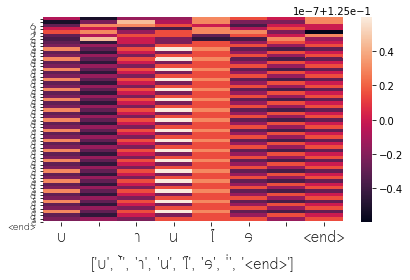

groundtruth: banrai
 prediction:  6(t2cdscdscdscdscdscdscdscdscdscdscdscdscdscdscdscdscdscdsc [25, 34, 38, 10, 26, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22, 21, 19, 22]



In [208]:
show_inference_example_attn(model, ['บ้านไร่'],  ['banrai'] ,char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)

    

In [180]:
print(char_2_ix)

{'<PAD>': 0, '<UNK>': 1, '<start>': 2, '<end>': 3, 'ก': 4, 'อ': 5, 'ง': 6, 'พ': 7, 'ั': 8, 'น': 9, 'ท': 10, 'ห': 11, 'า': 12, 'ร': 13, 'ป': 14, 'ื': 15, 'ใ': 16, 'ญ': 17, '่': 18, 'ว': 19, 'ิ': 20, 'ฑ': 21, 'ู': 22, 'ย': 23, '์': 24, 'เ': 25, 'ม': 26, 'ต': 27, 'บ': 28, 'ล': 29, 'ส': 30, '้': 31, 'ุ': 32, 'ษ': 33, 'แ': 34, 'ะ': 35, 'ศ': 36, 'ี': 37, 'ด': 38, 'ค': 39, 'ฆ': 40, 'โ': 41, '๋': 42, 'ช': 43, 'ไ': 44, 'จ': 45, 'ภ': 46, 'ณ': 47, 'ำ': 48, 'ฝ': 49, 'ข': 50, 'ผ': 51, 'ฒ': 52, 'ซ': 53, 'ธ': 54, '.': 55, ' ': 56, 'ถ': 57, 'ฐ': 58, 'ฏ': 59, 'ฟ': 60, 'ึ': 61, '็': 62, 'ฮ': 63, '๊': 64, 'ฉ': 65, 'ฎ': 66, '2': 67, 'ฌ': 68, 'ฬ': 69, '1': 70, '4': 71, '8': 72, '3': 73, 'ฯ': 74, 'ๆ': 75, '5': 76, '๙': 77, '7': 78, '0': 79, 'ฺ': 80, '6': 81, '9': 82, 'ฤ': 83, '-': 84, 'ฅ': 85, 'ๅ': 86, 'ฃ': 87, 'ฦ': 88, '"': 89, '!': 90, 'ํ': 91, '(': 92, ')': 93}


In [181]:
print(ix_to_target_char)

{0: '<PAD>', 1: '<start>', 2: '<end>', 3: 'k', 4: 'o', 5: 'n', 6: 'g', 7: 'p', 8: 'h', 9: 'a', 10: 't', 11: 'u', 12: 'e', 13: 'y', 14: 'i', 15: 'w', 16: 'm', 17: 'b', 18: 'l', 19: 's', 20: 'r', 21: 'd', 22: 'c', 23: 'f', 24: '-', 25: ' ', 26: '2', 27: '1', 28: '4', 29: '8', 30: '3', 31: '5', 32: '7', 33: '0', 34: '6', 35: '9', 36: '"', 37: '!', 38: '(', 39: ')'}


epoch=29, teacher_forcing_ratio=0.15


Loss  0.7274187803268433
Loss  0.5383312106132507
Loss  0.5050680637359619
Loss  0.5484542846679688
Loss  0.6379415392875671
Loss  0.6490351557731628
Loss  0.5977187156677246
Loss  0.4957181513309479
Loss  0.5053154230117798
Loss  0.5787795782089233
Loss  0.6386951804161072
groundtruth: maeo
 prediction: maeo [16, 9, 12, 4]

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

groundtruth: sunak
 prediction: sunak [19, 11, 5, 9, 3]

groundtruth: nok
 prediction: nok [5, 4, 3]

groundtruth: khwam-im
 prediction: khwam-im [3, 8, 15, 9, 16, 24, 14, 16]

groundtruth: kan narong
 prediction: kan narong [3, 9, 5, 25, 5, 9, 20, 4, 5, 6]

groundtruth: sakun
 prediction: sakun [19, 9, 3, 11, 5]

groundtruth: charin
 prediction: charin [22, 8, 9, 20, 14, 5]



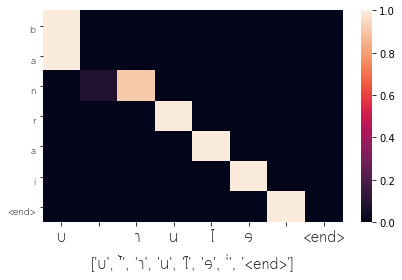

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

Evaluate F1,EM


Example: 1
      input: ขัตติยา กรีมี
groundtruth: khattiya krimi
 prediction: khattiya krimi

Example: 2
      input: คมสรร บุญทอง
groundtruth: khomsan bunthong
 prediction: khomsan bunthong

Example: 3
      input: ต่อเลขหมาย
groundtruth: tolekmai
 prediction: tolekmai

Example: 4
      input: กิตติศักดิ์ หวังวรวงศ์
groundtruth: kittisak wangworawong
 prediction: kittisak wangworawong

Example: 5
      input: สถาปัตยกรรมศาสตร์
groundtruth: sathapattayakamsat
 prediction: sathapattayakammasat

Example: 6
      input: กิมเจียว แซ่โง้ว
groundtruth: kimchiao sae-ngow
 prediction: kimchiao sae-ngow


F1 (macro-average) =  0.9893446245494757
EM =  0.896
EM (Character-level) =  0.9552857402847368
save best model em score=0.896 at epoch=29
Save model at epoch  29
Epoch: 30 | Time: 4m 48s
	Train Loss: 0.566 | Train PPL:   1.762
	 Val. Loss: 0.429 |  Val. PPL:   1.535
epoch=30, teacher_forcing_ratio=0.15


Loss  0.5168237090110779
Loss  0.4738193452358246
Loss  0.5493858456611633
Loss  0.5621632933616638
Loss  0.6470421552658081
Loss  0.5886804461479187
Loss  0.5375487804412842
Loss  0.6357995271682739
Loss  0.6048656702041626
Loss  0.5491631627082825
Loss  0.5968664884567261
groundtruth: maeo
 prediction: maeo [16, 9, 12, 4]

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

groundtruth: sunak
 prediction: sunak [19, 11, 5, 9, 3]

groundtruth: nok
 prediction: nok [5, 4, 3]

groundtruth: khwam-im
 prediction: khwam-im [3, 8, 15, 9, 16, 24, 14, 16]

groundtruth: kan narong
 prediction: kan narong [3, 9, 5, 25, 5, 9, 20, 4, 5, 6]

groundtruth: sakun
 prediction: sakun [19, 9, 3, 11, 5]

groundtruth: charin
 prediction: charin [22, 8, 9, 20, 14, 5]



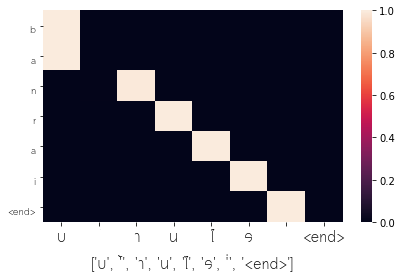

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

Evaluate F1,EM


Example: 1
      input: ขัตติยา กรีมี
groundtruth: khattiya krimi
 prediction: khattiya krimi

Example: 2
      input: คมสรร บุญทอง
groundtruth: khomsan bunthong
 prediction: khomsan bunthong

Example: 3
      input: ต่อเลขหมาย
groundtruth: tolekmai
 prediction: tolekmai

Example: 4
      input: กิตติศักดิ์ หวังวรวงศ์
groundtruth: kittisak wangworawong
 prediction: kittisak wangworawong

Example: 5
      input: สถาปัตยกรรมศาสตร์
groundtruth: sathapattayakamsat
 prediction: sathapattayakamasat

Example: 6
      input: กิมเจียว แซ่โง้ว
groundtruth: kimchiao sae-ngow
 prediction: kimchiao sae-ngow


F1 (macro-average) =  0.9893759166623687
EM =  0.89
EM (Character-level) =  0.9543428451435658
Epoch: 31 | Time: 4m 33s
	Train Loss: 0.545 | Train PPL:   1.725
	 Val. Loss: 0.432 |  Val. PPL:   1.541
epoch=31, teacher_forcing_ratio=0.15


Loss  0.547677755355835
Loss  0.5799933671951294
Loss  0.610641598701477
Loss  0.5610765814781189
Loss  0.5849884152412415
Loss  0.4781103730201721
Loss  0.5487290620803833
Loss  0.5629648566246033
Loss  0.5736099481582642
Loss  0.6624854803085327
Loss  0.5044180154800415
groundtruth: maeo
 prediction: maeo [16, 9, 12, 4]

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

groundtruth: sunak
 prediction: sunak [19, 11, 5, 9, 3]

groundtruth: nok
 prediction: nok [5, 4, 3]

groundtruth: khwam-im
 prediction: khwam-im [3, 8, 15, 9, 16, 24, 14, 16]

groundtruth: kan narong
 prediction: kan narong [3, 9, 5, 25, 5, 9, 20, 4, 5, 6]

groundtruth: sakun
 prediction: san [19, 9, 5]

groundtruth: charin
 prediction: charin [22, 8, 9, 20, 14, 5]



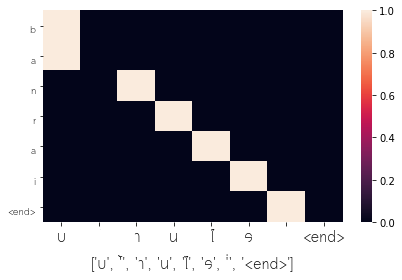

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

Evaluate F1,EM


Example: 1
      input: ขัตติยา กรีมี
groundtruth: khattiya krimi
 prediction: khattiya krimi

Example: 2
      input: คมสรร บุญทอง
groundtruth: khomsan bunthong
 prediction: khomsan bunthong

Example: 3
      input: ต่อเลขหมาย
groundtruth: tolekmai
 prediction: tolekmai

Example: 4
      input: กิตติศักดิ์ หวังวรวงศ์
groundtruth: kittisak wangworawong
 prediction: kittisak wangworawong

Example: 5
      input: สถาปัตยกรรมศาสตร์
groundtruth: sathapattayakamsat
 prediction: sapattayakammasat

Example: 6
      input: กิมเจียว แซ่โง้ว
groundtruth: kimchiao sae-ngow
 prediction: kimchiao sae-ngow


F1 (macro-average) =  0.988249567281885
EM =  0.872
EM (Character-level) =  0.9402127928610204
Epoch: 32 | Time: 4m 36s
	Train Loss: 0.562 | Train PPL:   1.755
	 Val. Loss: 0.456 |  Val. PPL:   1.577
epoch=32, teacher_forcing_ratio=0.15


Loss  0.5370351076126099
Loss  0.5887273550033569
Loss  0.5878713726997375
Loss  0.6558665037155151
Loss  0.6907453536987305
Loss  0.5880665183067322
Loss  0.5966131687164307
Loss  0.7550995945930481
Loss  0.598186731338501
Loss  0.7745717763900757
Loss  0.6270991563796997
groundtruth: maeo
 prediction: maeo [16, 9, 12, 4]

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

groundtruth: sunak
 prediction: sunak [19, 11, 5, 9, 3]

groundtruth: nok
 prediction: nok [5, 4, 3]

groundtruth: khwam-im
 prediction: khwam-im [3, 8, 15, 9, 16, 24, 14, 16]

groundtruth: kan narong
 prediction: kan narong [3, 9, 5, 25, 5, 9, 20, 4, 5, 6]

groundtruth: sakun
 prediction: sakun [19, 9, 3, 11, 5]

groundtruth: charin
 prediction: charin [22, 8, 9, 20, 14, 5]



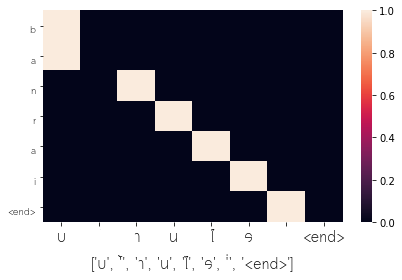

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

Evaluate F1,EM


Example: 1
      input: ขัตติยา กรีมี
groundtruth: khattiya krimi
 prediction: khattiya krimi

Example: 2
      input: คมสรร บุญทอง
groundtruth: khomsan bunthong
 prediction: khomsan bunthong

Example: 3
      input: ต่อเลขหมาย
groundtruth: tolekmai
 prediction: tolekmkamai

Example: 4
      input: กิตติศักดิ์ หวังวรวงศ์
groundtruth: kittisak wangworawong
 prediction: kittisak wangworawong

Example: 5
      input: สถาปัตยกรรมศาสตร์
groundtruth: sathapattayakamsat
 prediction: sathapattaakamasat

Example: 6
      input: กิมเจียว แซ่โง้ว
groundtruth: kimchiao sae-ngow
 prediction: kimchiao sae-ngow


F1 (macro-average) =  0.9652222572766578
EM =  0.836
EM (Character-level) =  0.920479663421466
Epoch: 33 | Time: 4m 36s
	Train Loss: 0.618 | Train PPL:   1.855
	 Val. Loss: 0.504 |  Val. PPL:   1.656
epoch=33, teacher_forcing_ratio=0.15


Loss  0.5664786100387573
Loss  0.5832512378692627
Loss  0.5735824108123779
Loss  0.6185986399650574
Loss  0.637225866317749
Loss  0.577375590801239
Loss  0.6269789934158325
Loss  0.5968617796897888
Loss  0.7298391461372375
Loss  0.6716881394386292
Loss  1.2181397676467896
groundtruth: maeo
 prediction: maeo [16, 9, 12, 4]

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

groundtruth: sunak
 prediction: sunak [19, 11, 5, 9, 3]

groundtruth: nok
 prediction: nok [5, 4, 3]

groundtruth: khwam-im
 prediction: khwam-im [3, 8, 15, 9, 16, 24, 14, 16]

groundtruth: kan narong
 prediction: kan narong [3, 9, 5, 25, 5, 9, 20, 4, 5, 6]

groundtruth: sakun
 prediction: sakun [19, 9, 3, 11, 5]

groundtruth: charin
 prediction: charin [22, 8, 9, 20, 14, 5]



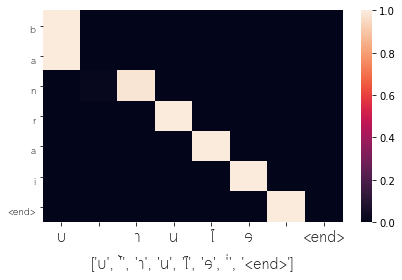

groundtruth: banrai
 prediction: banrai [17, 9, 5, 20, 9, 14]

Evaluate F1,EM


Example: 1
      input: ขัตติยา กรีมี
groundtruth: khattiya krimi
 prediction: khatatatatatatatatatatatatatatatatatatatatatatatatatatatatat

Example: 2
      input: คมสรร บุญทอง
groundtruth: khomsan bunthong
 prediction: khomsan bunthong

Example: 3
      input: ต่อเลขหมาย
groundtruth: tolekmai
 prediction: tolekmai

Example: 4
      input: กิตติศักดิ์ หวังวรวงศ์
groundtruth: kittisak wangworawong
 prediction: kitttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

Example: 5
      input: สถาปัตยกรรมศาสตร์
groundtruth: sathapattayakamsat
 prediction: sathapattaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Example: 6
      input: กิมเจียว แซ่โง้ว
groundtruth: kimchiao sae-ngow
 prediction: kimchuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu


F1 (macro-average) =  0.8753545016655968
EM =  0.666
EM (Character-level) =  0.7844875876212706
Epoch: 34 | Time: 4m 58s
	Train Loss: 0.655 | Train PPL:   1.926
	 Val. Loss: 0.871 |  Val. PPL:   2.389
epoch=34, teacher_forcing_

Loss  1.173588752746582
Loss  0.7683922052383423


KeyboardInterrupt: 

In [217]:
N_EPOCHS = 50
CLIP = 5

best_em_score = float('0.784')
teacher_forcing_ratio = 0.15

for epoch in range(29, N_EPOCHS):
    print('epoch={}, teacher_forcing_ratio={}'.format(epoch, teacher_forcing_ratio))
    model.train()
    start_time = time.time()
    train_loss = train(model, train_dataset_loader, optimizer, criterion, CLIP, teacher_forcing_ratio=teacher_forcing_ratio)
    teacher_forcing_ratio = max(teacher_forcing_ratio-0.000, 0.0)
    valid_loss = evaluate(model, val_dataset_loader, criterion)
    if epoch % 1 == 0:
        show_inference_example(model,
               ["แมว", "บ้านไร่", "สุนัข", "นก", "ความอิ่ม", "กานต์ ณรงค์", "สกุนต์", "ชารินทร์"],
               ["maeo", "banrai", "sunak", "nok", "khwam-im", "kan narong", "sakun", "charin"],
               char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)
        
        show_inference_example_attn(model, ['บ้านไร่'],  ['banrai'] ,char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)

        print('Evaluate F1,EM')
        
        f1_macro_average, em_score, em_char_score, _ = evaluate_inference(model, val_indices[:500])

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if em_score > best_em_score:
        best_em_score = em_score
        print('save best model em score={} at epoch={}'.format(em_score, epoch))
        save_model('thai2rom-pytorch.attn.v8', epoch, best_em_score, model)
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
 show_inference_example(model,
               ["แมว", "บ้านไร่", "สุนัข", "นก", "ความอิ่ม", "กานต์ ณรงค์", "สกุนต์", "ชารินทร์"],
               ["maeo", "banrai", "sunak", "nok", "khwam-im", "kan narong", "sakun", "charin"],
               char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)
        

In [0]:
print(thai_romanization_dataset.input_texts[5000:5010])
print(thai_romanization_dataset.target_texts[5000:5010])

['บ้านปางสามัคคี', 'บ้านหนองนาเวียง', 'มณฑลกานสู้', 'บ้านโนนหมากมุ่น', 'นัว', 'การเลือกตั้งพิเศษ', 'มัลกะ', 'ทหารกองหนุน', 'ตำบลวังสรรพรส', 'พร้อย']
['banpangsamakkhi', 'bannongnawiang', 'monthonkansu', 'bannonmakmun', 'nua', 'kanlueaktangphiset', 'manka', 'thahankongnun', 'tambonwangsappharot', 'phroi']


numericalized [19, 20, 21, 22, 13, 23, 24, 3]
sentence_length [8]
1: วิฑูรย์ -> 83454r4iri88h8kak454r4iri88h8k8k454r4iri88h8k8k454r4iri88h8k



## Evaluation on val_set with following metrics:
   
1. F1-score (macro-average) -- Character level

2. Exact Match (EM)

3. Exact Match (EM) - Character level

    

In [211]:
# Functions for model performance evaluation
def precision(pred_chars, target_chars):
    # TP / TP + FP
    pred_chars_multiset = Counter(pred_chars)
    target_chars_multiset = Counter(target_chars)

    overlap = list((pred_chars_multiset & target_chars_multiset).elements())
    n_overlap = len(overlap)

    return n_overlap / max(len(pred_chars), 1)

def recall(pred_chars, target_chars):
    # TP / TP + FN
        
    pred_chars_multiset = Counter(pred_chars)
    target_chars_multiset = Counter(target_chars)

    overlap = list((pred_chars_multiset & target_chars_multiset).elements())
    n_overlap = len(overlap)
    return n_overlap / len(target_chars)

def f1(precision, recall):
    
    return (2  * precision * recall) / (precision + recall)

def em(pred, target):
    if pred == target:
        return 1
    return 0

def em_char(pred_chars, target_chars):
    N_target_chars = len(target_chars)
    N_pred_chars = len(pred_chars)

    score = 0
    for index in range(min(N_pred_chars, N_target_chars)):
        if target_chars[index] == pred_chars[index]:
            score+=1
            
    return score / max(N_target_chars, N_pred_chars)

In [220]:
def evaluate_inference(model, val_indices):
    cumulative_precision = 0
    cumulative_recall = 0
    cumulative_em = 0
    cumulative_em_char = 0
    
    N = len(val_indices)

    epoch_loss = 0
    prediction_results = []
    em_char_score = 0
    for i, val_index in tqdm(enumerate(val_indices), total=N):
        input_text = thai_romanization_dataset.input_texts[val_index]
        target_text = thai_romanization_dataset.target_texts[val_index]

        
        prediction, indices, _ = inference(model, input_text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)
        prediction_results.append(prediction)
        if i <= 15:
            print('Example: {}'.format(i+1))
            print('      input: {}'.format(input_text))
            print('groundtruth: {}'.format(target_text))
            print(' prediction: {}\n'.format(prediction))

        pred_chars = [char for char in prediction]
        target_chars = [char for char in target_text]

        cumulative_precision += precision(pred_chars, target_chars)
        cumulative_recall +=  recall(pred_chars, target_chars)
        cumulative_em_char += em_char(pred_chars, target_chars)
        cumulative_em += em(prediction, target_text)

    macro_average_precision = cumulative_precision / N
    macro_average_recall = cumulative_recall /N
    f1_macro_average = f1(macro_average_precision, macro_average_recall) 
    em_score = cumulative_em / N
    em_char_score = cumulative_em_char / N
    print('')
    print('F1 (macro-average) = ', f1_macro_average)
    print('EM = ', em_score)
    print('EM (Character-level) = ', em_char_score)


    return f1_macro_average, em_score, em_char_score, prediction_results



In [221]:
data = load_model('./thai2rom-pytorch.attn.v8.best_epoch-29.tar')

_model = data['model']
_model           

char_to_ix = data['char_to_ix']
ix_to_char =  data['ix_to_char']
target_char_to_ix = data['target_char_to_ix']
ix_to_target_char = data['ix_to_target_char']

In [ ]:
evaluate_inference(_model, val_indices[:])

Example: 1
      input: ขัตติยา กรีมี
groundtruth: khattiya krimi
 prediction: khattiya krimi

Example: 2
      input: คมสรร บุญทอง
groundtruth: khomsan bunthong
 prediction: khomsan bunthong

Example: 3
      input: ต่อเลขหมาย
groundtruth: tolekmai
 prediction: tolekmai

Example: 4
      input: กิตติศักดิ์ หวังวรวงศ์
groundtruth: kittisak wangworawong
 prediction: kittisak wangworawong

Example: 5
      input: สถาปัตยกรรมศาสตร์
groundtruth: sathapattayakamsat
 prediction: sathapattayakammasat

Example: 6
      input: กิมเจียว แซ่โง้ว
groundtruth: kimchiao sae-ngow
 prediction: kimchiao sae-ngow

Example: 7
      input: เขยื้อน รังสิยีรานนท์
groundtruth: khayuean rangsiyiranon
 prediction: khayuean rangsiyiranon

Example: 8
      input: ขนิษฐา เสมอใจ
groundtruth: khanittha samoechai
 prediction: khanittha samoechai

Example: 9
      input: กนกกุล หวังบุญผาติ
groundtruth: kanokkun wangbunphati
 prediction: kanokkun wangbunphat

Example: 10
      input: จรัล กิติสาย
groundtruth: charan k